![header](images/header.png)

# Warmup run

<br>
<br>
<br>

The purpose of the warmup run is to obtain the model state variables at the beginning of the period of interest. Hence, the model is run from the beginning of the meteorological data (01-01-1979) to the timestep prior to the beginning of the period of interest (31-12-1989). The initial conditions are set as default values, but we use the two outputs of the initialization run to set the average discharge (`avgdis`) and the average inflow into the lower groundwater zone (`lzavin`). From this run we want as a result only the map of the state variables at the end of the simulation.

This run is not necessary in many studies. We have created this run only to show how the end maps of one simulation can be used as the initial conditions in the succeeding simulation, as it would be done in an operational forecasting system, for instance. This warmup run could be replaced by extending the final run a few years and discarding those first few years from the results. As explained in the [User Guide](https://ec-jrc.github.io/lisflood-code/3_step5_model-initialisation/), the length of time to be discarded depends on the "memory" of the water storages inside the model, which is usually in the order of months. A possible way to estimate the necessary time would be to run the model with completely different initial conditions and check when the results converge; from that moment on, the results are reliable.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from lisflood_read_plot import *

path_model = Path('../../model/')

## 1 Settings file

With all this in mind, the most relevant changes on the settings file ([_settings_warmup.xml_](../../model/settings_warmup.xml)) are shown in the following snippet:

```xml
<lfoptions>
    
    # [...]
    
    # option to initialize Lisflood
    <setoption choice="0" name="InitLisflood"/>
    
    # report end state maps
    <setoption choice="1" name="repEndMaps"/>
    
    # report map stack of the lower groundwater zone
    # (this option is not necessary, only for educational purposes)
    <setoption choice="0" name="repStateMaps"/>
    <setoption choice="1" name="repLZMaps"/>
    
    # [...]
    
</lfoptions>

<lfuser>
    
    # [...]
    
    # time-related variables
    <textvar name="CalendarDayStart" value="02-01-1979 00:00"/>
    <textvar name="StepStart" value="02-01-1979 00:00"/>
    <textvar name="StepEnd" value="01-01-1990 00:00"/>
    <textvar name="timestepInit" value="02-01-1979 00:00"/>
    <textvar name="ReportSteps" value="1..9999"/>
    <textvar name="DtSec" value="86400"/>
    <textvar name="DtSecChannel" value="14400"/>
    
    # paths
    <textvar name="PathInit" value="$(PathRoot)/initial"/>
    <textvar name="PathOut" value="$(PathRoot)/out/warmup"/>
    
    # files where the end state maps will be saved
    # (only a few of them are shown for the sake of brevity)
    <textvar name="ReservoirFillEnd" value="$(PathInit)/rsfil"/>
    <textvar name="Theta1End" value="$(PathInit)/tha_end"/>
    <textvar name="Theta2End" value="$(PathInit)/thb_end"/>
    <textvar name="Theta3End" value="$(PathInit)/thc_end"/>
    <textvar name="UZEnd" value="$(PathInit)/uz_end"/>
    <textvar name="LZEnd" value="$(PathInit)/lz_end"/>
    # [...]
    
    # file where the output map stack will be saved
    <textvar name="LZState" value="$(PathOut)/lz"/>
    
    # [...]
    
</lfuser>

<lfbinding>
    
    [...]
    
    # files from where to read the initialized variables
    <textvar name="LZAvInflowMap" value="$(PathInit)/lzavin"/>
    <textvar name="AvgDis" value="$(PathInit)/avgdis"/>
    
    [...]
    
</lfbinding>
```

In the `<lfoptions>` section, the initialization model is deactivated, and several options that control the outputs reported by the simulation must be activated. In the succeeding run, we need to use the end state of this warmup run as the initial state; for that, the option `repEndMaps` is activated, which will create a NetCDF map for each state variable at the last timestep of the simulation. Only for the sake of showing another way of defining the initial conditions, we decided to report the map stack (evolution over time) of the lower groundwater storage; to do so, we can keep the option `repStateMaps` deactivated, but we must switch on the option `repLZMaps`.

In the `<lfuser>` section, the first thing to do is to set the start and end of the simulation, and make sure that results are reported every timestep with the variable `ReportSteps`. Then, the name and location of the output maps are defined; these maps represent the model state variables at the last timestep of the simulation, and the stack map of the lower groundwater zone storage. For the sake of simplicity, in the snippet above only a few of them are shown. We chose to save the end maps in the _initial_ subfolder of the project, together with the outputs of the initialization run, whereas the map stack will be saved in the subfolder _output/warmup_.

In the `<lfbinding>` element, we must define the initialization maps we've just created in the [initialization run](1_initialization.ipynb).

## 2 Run the simulation

To run the simulation, open a terminal, activate the Conda environment where you have installed LISFLOOD and execute the `lisflood` function pointing at the appropriate settings file. For instance:

```shell
conda activate your_lisflood_environment
lisflood <path_where_you_saved_the_repository>/lisflood-usecases/LF_mekong_usecase/model/settings_warmup.xml
```

## 3 Output

The output of the warmup run are a series of NetCDF maps (subfolder _initial_) representing the state variables at the end of the simulation, and 1 NetCDF map stack (subfolder _out/warmup_) with the evolution of the lower groundwater zone storage. You must take into account that, depending on the modules activated in your LISFLOOD model, some end maps will be or will not be created.

### 3.1 End state maps 

The end state maps will be the initial conditions for the succeeding run. In this example, they are the model state variables at 31-12-1989 (remember that this date is 01-01-1990 in LISFLOOD end-of-timestep notation). Let's visualize some of those maps.

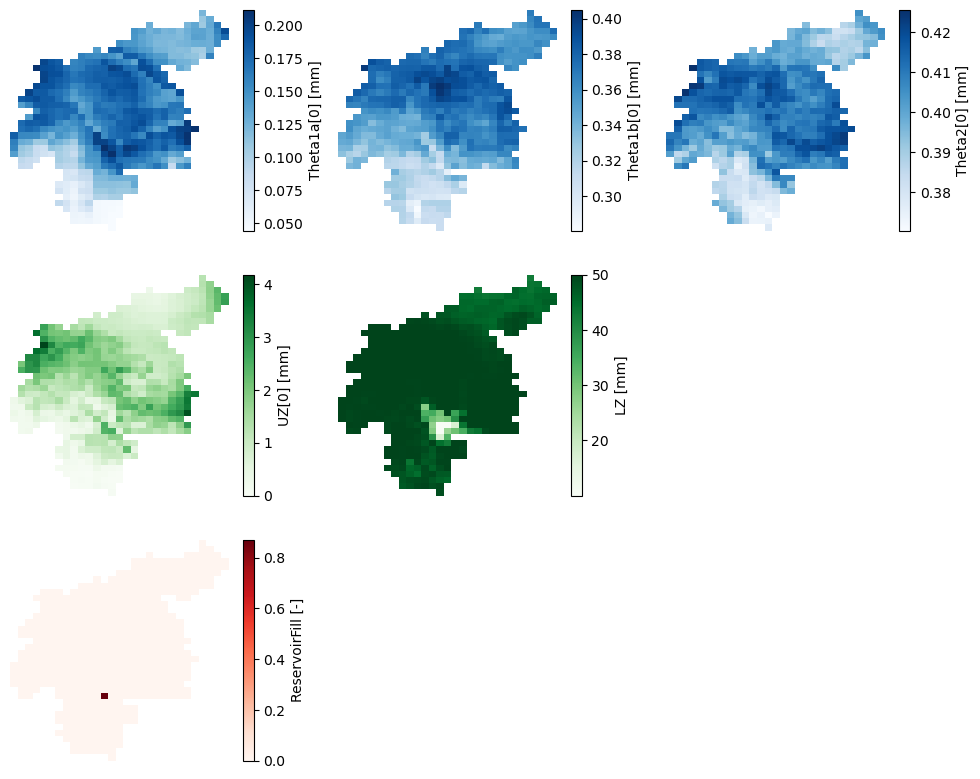

In [2]:
# load some end state maps (initial conditions for the run)
init_cond = {}
for var in ['tha', 'thb', 'thc', 'uz', 'lz', 'rsfil']:
    da = xr.open_dataarray(path_model / 'initial' / f'{var}_end.nc')
    da.close()
    init_cond[var] = da

# plot end conditions
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 9.75))
plot_config = {'soil': {'keys': ['tha', 'thb', 'thc'], 'cmap': 'Blues'},
               'groudwater': {'keys': ['uz', 'lz'], 'cmap': 'Greens'},
               'reservoir': {'keys': ['rsfil'], 'cmap': 'Reds'}}
for row, (group, config) in enumerate(plot_config.items()):
    for col, key in enumerate(config['keys']):
        init_cond[key].plot(ax=axes[row, col], cmap=config['cmap'])
        axes[row, col].axis('off')
        if col < 2:
            for col in range(col + 1, 3):
                axes[row, col].axis('off')

***Figure 1**. Maps of the model state variables at the end of the warmup run.*

The maps above represent:

* The first row is the water content in the three soil layers. From left to right, $\theta_{1a}$ for superficial soil, $\theta_{1b}$ for the upper soil, and $\theta_{2}$ for the lower soil.
* The second row represents groundwater storages: $UZ$ for the upper groundwater zone, and $LZ$ for the lower groundwater zone.
* The last row represents the relative filling of reservoirs (only one in this catchment).

The water content maps here shown correspond only to the "other" land use fraction, i.e., any but forest, irrigated or sealed. Similar maps were generated for the forest and irrigated fractions, whereas for the sealed fraction none of these maps apply, as there is no infiltration in impermeable surfaces.

The reservoir relative filling map has only one cell with a value different from 0, which is the cell representing the reservoir. Let's find out what's the initial condition for the relative filling of the reservoir:

In [3]:
print('Initial relative filling: {0:.1f}%'.format(np.nanmax(np.unique(init_cond['rsfil'])) * 100))

Initial relative filling: 87.0%


### 3.2 Map stack of state variables

We have defined in the settings file that we want to write the map stack of the lower groundwater zone storage. As mentioned earlier, this is not a compulsory step. It was done to show another possible way of defining the initial conditions on the main run, and to prove why a warmup period is necessary.

This output differs from the end maps, since it has a temporal third dimension. Let's inspect the resulting NetCDF file.

Last timestep: 1990-01-01T00:00:00.000000000


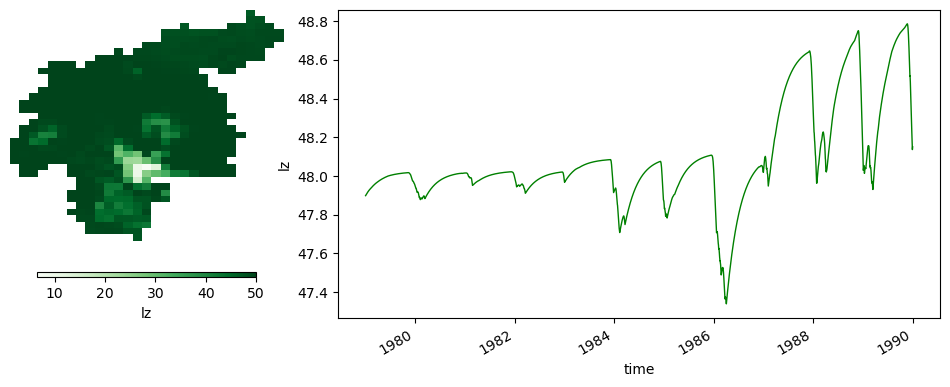

In [4]:
# load map stacks of lower groundwater zone storage
da = xr.open_dataarray(path_model / 'out' / 'warmup' / 'lz.nc')
da.close()

# plot map of average over time and timeseries of areal average
plot_map_timeseries(da, cmap='Greens', color='green')

print('Last timestep: {0}'.format(da['time'].isel(time=-1).data))

***Figure 2**. Evolution of the lower groundwater storage throughout the warmup run. The map on the left represents the average water storave over time, whereas the lineplot on the right the evolution over time of the average catchment water storage.*

The lineplot above proves why it is necessary to warm up the model. The default initial condition we used as a starting point for this run (02-01-1979) differs from the end condition (01-01-1990). Even though the differences may seem small in this case, they can make the difference in the succeeding run. 

The last timestep of this map stack may be used as the initial condition for the suceeding run, instead of the end map in _initial/lz.nc_, since they are the same. In the following notebook we will cover how to set this last map as the initial conditions.